In [1]:
%matplotlib inline  

In [2]:
!pip install aletheia

In [4]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from sklearn.utils import check_X_y
import torch
import time
import random
import numpy as np
import os
import numpy
import pandas
import seaborn
from matplotlib import pyplot
import matplotlib.pyplot as plt
import aletheia
from re import search
import aletheia
import sklearn
import torch.nn as nn
from sklearn.preprocessing import StandardScaler , MinMaxScaler
import pandas as pd
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
import warnings
import torch.optim as optim
from tqdm import tqdm
from tqdm import tqdm_notebook
from tqdm import tqdm
from torch.utils.data import Dataset
#from torch.utils.data import DataLoader
from typing import List, Tuple
from sklearn.metrics import *
from matplotlib import pylab as plt
import seaborn as sns
import itertools
#from sklearn.datasets import make_friedman1
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
#  some codes are from https://github.com/SelfExplainML/Aletheia/blob/master/examples/demo-pytorch.ipynb

In [4]:

class ModelDataset(Dataset):

    def __init__(self, data: np.ndarray, labels: np.ndarray):
        """Constructor to initialize data and class labels.
        Parameters
        ----------
        data : np.ndarray
            A numpy ndarray of shape (n_samples,n_features)
        labels : np.ndarray
            A numpy ndarray of shape (n_classes)
        """
        super(ModelDataset, self).__init__()
        self.data = data
        self.labels = labels

    def __getitem__(self, idx) -> torch.tensor:
        """Support the indexing such that data[idx], label[idx] can be used to get ith sample
        Parameters
        ----------
        idx :
            Indices/Keys to get the ith sample of data and labels
        Returns
        -------
        torch.tensor
            data: torch.Tensor of size (batch_size,n_features)
            labels: torch.Tensor of size (batch_size)
        """
        return self.data[idx], self.labels[idx]

    def __len__(self) -> int:
        """To return the size of the dataset using len(data)
        Returns
        -------
        int
            size of dataset
        """
        return len(self.data)

    def get_dataloader(self, batch_size: int, num_workers: int = 0, shuffle: bool = False, batch_first: bool = True, pin_memory: bool = False) -> object:
        """Initializes the  DataLoader class. It combines a dataset and a sampler, and provides an iterable over the given dataset.
        Parameters
        ----------
        batch_size : int
            how many samples per batch to load
        num_workers : int, optional
            how many subprocesses to use for data loading, by default 0
        shuffle : bool, optional
            set to True to have the data reshuffled at every epoch, by default False
        batch_first : bool, optional
            Samples the data such that batch_size should be first dimension, by default True
        pin_memory : bool, optional
            If True, the data loader will copy Tensors into CUDA pinned memory before returning them, by default False
        Returns
        -------
        object
            A DataLoader object to generate batch sized data
        """
        batch_obj = DataLoader(self, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)
        return batch_obj


class ReLU_DNN(nn.Module):

    def __init__(self, net_size: List[Tuple]):
        """Initializes a Neural Network with ReLU activation (self.net).
        Parameters
        ----------
        net_size : list[tuple], len(list) is n_layers
            Layer sizes (tuple) (n_neurons[n_layer], n_neurons[n_layer+1])
        """
        super(ReLU_DNN, self).__init__()
        self.layers = []
        for size in net_size[:-1]:
            self.layers.append(nn.Linear(size[0], size[1]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(net_size[-1][0], net_size[-1][1]))
        self.net = nn.Sequential(*self.layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Performs forward pass through the Neural Network
        Parameters
        ----------
        x : torch.Tensor
            Input data of size (batch_size, n_features)
        Returns
        -------
        torch.Tensor
            Output from the last layer of the Neural Network.
        """
        final_output = self.net(x)
        return final_output


class Trainer():

    def __init__(self, hidden_layer_sizes: list, epochs: int, learning_rate: float, device: str, loss_fn: torch.nn.modules.loss, l1_reg: float, l2_reg: float, batch_size: int):
        """Constructor for Trainer object.
        Parameters
        ----------
        hidden_layer_sizes : list
            A list of hidden layer sizes
        epochs : int
            Number of training epochs
        learning_rate : float
            learning rate for model training
        device : str
            Computational device: cuda or cpu
        loss_fn : torch.nn.modules.loss
            Loss function used by optimizer
            MSELoss() for regression problem
            BCEWithLogitsLoss() for classification problem
        l1_reg : float
            lambda parameter for L1 Regularization
        l2_reg : float
            lambda parameter for L2 Regularization
        batch_size : int
            Batch size for training
        """
        self.hidden_layer_sizes = hidden_layer_sizes
        self.epochs = epochs
        self.lr = learning_rate
        self.loss_fn = loss_fn
        self.l1_lambda = l1_reg
        self.l2_lambda = l2_reg
        self.batch_size = batch_size
        self.device = device

    def validate_input(self, labels: np.ndarray) -> np.ndarray:
        """Reshapes the labels ndarray to (batch_size, 1) and converts entries to float data type
        Parameters
        ----------
        labels : np.ndarray
            Data labels of shape (n_classes)
        Returns
        -------
        np.ndarray
            numpy ndarray with (batch_size, 1) shape
        """
        if labels.ndim != 2:
            labels = np.reshape(labels, (-1, 1))
        return labels.astype(float)

    def get_data_loader(self, x: np.ndarray, y: np.ndarray, shuffle: bool = False) -> object:
        """Initializes the dataset (data, labels) and return a batch sized data loader.
        Parameters
        ----------
        x : np.ndarray
            Data features of shape (n_samples, n_features)
        y : np.ndarray
            Data labels of shape (n_classes)
        shuffle : bool
            set to True to have the data reshuffled at every epoch, by default False
        Returns
        -------
        object
            An iterator object to iterate over the data.
        """
        dataobj = ModelDataset(x, y)
        data_loader = dataobj.get_dataloader(batch_size=self.batch_size, shuffle=shuffle)
        return data_loader
    
    def init_weights(self,layer):
        """Performs weight initialization for the network using Kaiming Normal initializer
        Parameters
        ----------
        layer : model layer
            Perform initialization over model weights with Kaiming Normal initializer
        """
        if type(layer) == nn.Linear:
            nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')  
            nn.init.zeros_(layer.bias)

    def build_model(self, data_x: np.ndarray):
        """Builds a ReLU DNN model
        Parameters
        ----------
        data_x : np.ndarray
            Data features of shape (n_samples, n_features)
        """
        input_size = data_x.shape[1]
        output_size = 1
        hidden_list = [input_size] + self.hidden_layer_sizes + [output_size]
        hidden_tuples = [(hidden_list[i], hidden_list[i + 1]) for i in range(len(hidden_list) - 1)]
        model = ReLU_DNN(hidden_tuples)
        self.model = model.net.double()
        self.model.apply(self.init_weights)
        if torch.cuda.is_available():
            self.model = self.model.to(device=self.device)

    def get_params(self):
        """Retrieves the parameters i.e, weights (List[torch.Tensor]) and biases (List[torch.Tensor]) of the model
        Attributes
        ----------
        weights : list of shape (n_layers - 1,).
            The ith element in the list represents the weight matrix corresponding to layer i.
        biases : list of shape (n_layers - 1,).
            The ith element in the list represents the bias vector corresponding to layer i + 1.
        """
        self.weights = []
        self.biases = []
        for name, params in self.model.named_parameters():
            if 'weight' in name:
                self.weights.append(torch.transpose(params, 0, 1).detach())
            elif 'bias' in name:
                self.biases.append(params.detach())

    def calc_l1reg_loss(self, loss: torch.Tensor) -> torch.Tensor:
        """Calculates L1 Regularized loss
        Parameters
        ----------
        loss : torch.Tensor
            A tensor containing loss value

        Returns
        -------
        torch.Tensor
            A tensor containing L1 regularized loss value
        """
        l1_reg = torch.tensor(0.0, dtype=torch.double, device=self.device)
        for name,params in self.model.named_parameters():
            if "weight" in name:
                l1_reg += torch.norm(params, 1)
        loss = loss + self.l1_lambda * l1_reg
        return loss

    def train(self, data_loader: object):
        """Trains a ReLU DNN model for a given no of epochs.
        Parameters
        ----------
        data_loader : object
            An iterator object to iterate over the dataset (batch_size).
        """
        self.model.train()
        self.loss = []
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epochs in range(self.epochs):
            epoch_loss = 0
            for batch_no, train_batch in enumerate(data_loader):
                data, labels = train_batch[0].to(device=self.device).double(), train_batch[1].to(device=self.device).double()
                prediction = self.model(data)
                loss = self.loss_fn(prediction, labels)
                if self.l1_lambda > 0.0:
                    loss = self.calc_l1reg_loss(loss)
                if self.l2_lambda > 0.0:
                    loss = self.calc_l2reg_loss(loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            self.loss.append(epoch_loss)
        self.get_params()

class ReluNetClassifier(Trainer):

    def __init__(self, hidden_layer_sizes: list, epochs: int, device: str, learning_rate: float = 0.01, l1_reg: float = 0, l2_reg: float = 0, batch_size: int = 100):
        """Classifier object inherits Trainer object.
           This function is the constructor for both Trainer and Classifier objects.
        Parameters
        ----------
        hidden_layer_sizes : list
            A list of hidden layer sizes
        epochs : int
            Number of training epochs
        device : str
            Computational device: cuda or cpu
        learning_rate : float, optional
            learning rate for model training, by default 0.01
        l1_reg : float, optional
            lambda parameter for L1 Regularization, by default 0
        l2_reg : float, optional
            lambda parameter for L2 Regularization, by default 0
        batch_size : int, optional
            Batch size for training, by default 100
        """
        super(ReluNetClassifier, self).__init__(hidden_layer_sizes=hidden_layer_sizes, epochs=epochs, learning_rate=learning_rate, device=device, loss_fn=nn.BCEWithLogitsLoss(), l1_reg=l1_reg, l2_reg=l2_reg, batch_size=batch_size)

    def fit(self, data_x: np.ndarray, labels: np.ndarray):
        """Builds a ReLU DNN model for given data and calls train function to train the model
        Parameters
        ----------
        data_x : np.ndarray
            Training data features of shape (n_samples, n_features)
        labels : np.ndarray
            Training data labels of shape (n_classes)
        """
        labels = self.validate_input(labels)
        self.build_model(data_x)
        data_loader = self.get_data_loader(x=data_x, y=labels, shuffle=True)
        self.train(data_loader)

    def perform_eval(self, data_x: np.ndarray, labels: np.ndarray) -> float:
        """Performs evaluation on the test data using trained model and returns accuracy of the model.
        Parameters
        ----------
        data_x : np.ndarray
            Test data features of shape (n_samples, n_features)
        labels : np.ndarray
            Test data labels of shape (n_classes)
        Returns
        -------
        float
            Accuracy of the model on test data
        """
        self.model.eval()
        self.batch_size = data_x.shape[0]
        labels = self.validate_input(labels)
        data_loader = self.get_data_loader(x=data_x, y=labels, shuffle=False)
        for batch_no, val_batch in enumerate(data_loader):
            data, labels = val_batch[0].to(device=self.device).double(), val_batch[1].to(device=self.device).double()
            with torch.no_grad():
                prediction = self.model(data)
                pred_labels = torch.round(torch.sigmoid(prediction))
                correct_results_sum = (pred_labels == labels).sum().float()
                acc = correct_results_sum / labels.shape[0]
                acc = torch.round(acc * 100)
        return acc.item()

    def predict_proba(self, data_x: np.ndarray) -> np.ndarray:
        """Returns numpy array of predicted probabilities of being classified as class 1 on test data
        Parameters
        ----------
        data_x : np.ndarray
            Test data features of shape (n_samples, n_features)
        Returns
        -------
        np.ndarray
            numpy array of predicted probabilities
        """
        self.model.eval()
        data = torch.from_numpy(data_x).to(device=self.device)
        with torch.no_grad():
            prediction = self.model(data.double())
            proba = torch.sigmoid(prediction)
        return proba.cpu().numpy()


In [5]:
import  torch 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

"""
if torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"
"""
print(device)

cuda:0
cuda:0


In [6]:
import numpy as np

def calculate_psi(expected, actual, buckettype='bins', buckets=15, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [7]:
class my_dictionary(dict):

    # __init__ function
    def __init__(self):
        self = dict()

    # Function to add key:value
    def add(self, key, value):
        self[key] = value



In [8]:
data = pd.read_csv("data path path here"+"BreastCancerData.csv",delimiter=',')

In [9]:

data = data.drop("id",1)
data = data.drop("Unnamed: 32",1)

In [10]:
#Mapping M to 1 and B to 0 in the output Label DataFrame
data['diagnosis']=data['diagnosis'].map({'M':1,'B':0})

In [11]:
data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [12]:
x = data.drop(columns="diagnosis").to_numpy()

In [13]:
y = data.iloc[: , 0].to_numpy()

In [14]:
#data = data.sample(frac=0.3, replace=False , random_state = 1)

In [15]:
#plt.hist(y)

In [16]:
mm = MinMaxScaler()
x = mm.fit_transform(x)


In [17]:
def Plot_AUC(Dic_AUC):
    dd = pandas.DataFrame(Dic_AUC)
    dd['legend'] = ["AUC", "AUC","AUC","AUC","AUC","AUC","AUC","AUC","AUC","AUC"]
    fig2, axx = plt.subplots()
    axx = (
    dd.set_index("legend", append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Seed', 0: 'AUC'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Seed', y='AUC', hue="legend", hue_order=["AUC"])  
    )
    seaborn.despine(trim=True)
    plt.show()
    
def Compare_AUC(AUC_drop_out,AUC_l1):
    d1 = pandas.DataFrame(AUC_drop_out)
    d1['legend'] = ["Drop Out", "Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out"]
    
    d2 = pandas.DataFrame(AUC_l1)
    d2['legend'] = ["L1", "L1","L1","L1","L1","L1","L1","L1","L1","L1"]
    
    df_concat = pd.concat([d1, d2], axis=0)
    fig2, axx = plt.subplots()
    axx = (
    df_concat.set_index("legend", append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Seed', 0: 'AUC'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Seed', y='AUC', hue="legend", hue_order=["Drop Out","L1"])  
    )
    seaborn.despine(trim=True)
    plt.show()

In [18]:
def Plot_LLM(Dic_Local_Models):
    dd = pandas.DataFrame(Dic_Local_Models)
    dd['legend'] = ["M", "M","M","M","M","M","M","M","M","M"]
    fig2, axx = plt.subplots()
    axx = (
    dd.set_index("legend", append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Seed', 0: '#LLM'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Seed', y='#LLM', hue="legend", hue_order=["M"])  
    )
    seaborn.despine(trim=True)
    plt.show()
    
def Compare_LLM(LLM_drop_out,LLM_l1):
    d1 = pandas.DataFrame(LLM_drop_out)
    d1['legend'] = ["Drop Out", "Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out"]
    
    d2 = pandas.DataFrame(LLM_l1)
    d2['legend'] = ["L1", "L1","L1","L1","L1","L1","L1","L1","L1","L1"]
    
    df_concat = pd.concat([d1, d2], axis=0)
    fig2, axx = plt.subplots()
    axx = (
    df_concat.set_index("legend", append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Seed', 0: '#LLM'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Seed', y='#LLM', hue="legend", hue_order=["Drop Out","L1"])  
    )
    seaborn.despine(trim=True)
    plt.show()

In [19]:
####   For plotting 
def Compare_AUC(AUC_AUC_mlp, AUC_mlp_iht_l1):
    d1 = pandas.DataFrame(AUC_AUC_mlp)
    d1['legend'] = ["mlp", "mlp","mlp" ,"mlp","mlp","mlp","mlp","mlp","mlp","mlp"]
    
    d2 = pandas.DataFrame(AUC_mlp_iht_l1)
    d2['legend'] = ["mlp_iht_l1", "mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1"]
    
    df_concat = pd.concat([d1, d2], axis=0)
    fig2, axx = plt.subplots()
    axx = (
    df_concat.set_index("legend", append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Compare AUC', 0: 'AUC'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Compare AUC', y='AUC', hue="legend", hue_order=["mlp","mlp_iht_l1"])  
    )
    seaborn.despine(trim=True)
    plt.show()
    
def Compare_LLM(LLM_drop_out,LLM_l1):
    d1 = pandas.DataFrame(LLM_drop_out)
    d1['legend'] = ["mlp", "mlp","mlp","mlp","mlp","mlp","mlp","mlp","mlp","mlp"]
    
    d2 = pandas.DataFrame(LLM_l1)
    d2['legend'] = ["mlp_iht_l1", "mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1"]
    
    df_concat = pd.concat([d1, d2], axis=0)
    fig2, axx = plt.subplots()
    axx = (
    df_concat.set_index("legend", append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Compare #LLM', 0: '#LLM'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Compare #LLM', y='#LLM', hue="legend", hue_order=["mlp","mlp_iht_l1"])  
    )
    seaborn.despine(trim=True)
    plt.show()
    
def Compare_dif_AUC(dif_AUC_AUC_mlp, dif_AUC_mlp_iht_l1):
    d1 = pandas.DataFrame(dif_AUC_AUC_mlp)
    d1['legend'] = ["mlp", "mlp","mlp","mlp","mlp","mlp","mlp","mlp","mlp","mlp"]
    
    d2 = pandas.DataFrame(dif_AUC_mlp_iht_l1)
    d2['legend'] = ["mlp_iht_l1", "mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1"]
    
    df_concat = pd.concat([d1, d2], axis=0)
    fig2, axx = plt.subplots()
    axx = (
    df_concat.set_index("legend", append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Copmare dif AUC', 0: 'dif AUC'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Copmare dif AUC', y='dif AUC', hue="legend", hue_order=["mlp","mlp_iht_l1"])  
    )
    seaborn.despine(trim=True)
    plt.show()
    
#########
def Comapre_IQ_mean_width(width_drop_out,width_l1):
    d1 = pandas.DataFrame(width_drop_out)
    d1['legend'] = ["mlp", "mlp","mlp","mlp","mlp","mlp","mlp","mlp","mlp","mlp"]
    
    d2 = pandas.DataFrame(width_l1)
    d2['legend'] = ["mlp_iht_l1", "mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1",
                    "mlp_iht_l1","mlp_iht_l1","mlp_iht_l1"]
    
    df_concat = pd.concat([d1, d2], axis=0)
    fig2, axx = plt.subplots()
    axx = (
    df_concat.set_index("legend", append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Compare IQ_mean_width', 0: 'IQ_mean_width'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Compare IQ_mean_width', y='IQ_mean_width', hue="legend", hue_order=["mlp","mlp_iht_l1"])  
    )
    seaborn.despine(trim=True)
    plt.show()
    

def Comapre_IQ_width(width_drop_out,width_l1):
    d1 = pandas.DataFrame(width_drop_out)
    d1['legend'] = ["mlp", "mlp","mlp","mlp","mlp","mlp","mlp","mlp","mlp","mlp"]
    
    d2 = pandas.DataFrame(width_l1)
    d2['legend'] = ["mlp_iht_l1", "mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1","mlp_iht_l1",
                    "mlp_iht_l1","mlp_iht_l1","mlp_iht_l1"]
    
    df_concat = pd.concat([d1, d2], axis=0)
    fig2, axx = plt.subplots()
    axx = (
    df_concat.set_index("legend", append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Compare IQ_width', 0: 'IQ_width'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Compare IQ_width', y='IQ_width', hue="legend", hue_order=["mlp","mlp_iht_l1"])  
    )
    seaborn.despine(trim=True)
    plt.show()


In [20]:
from scipy import stats   
def comapre_AUC(dic_mlp , dic_mlp_iht_l1):
    N = []
    for i in list(dic_mlp.keys()):
       for j in dic_mlp[i]:
           N.append(j)
    N_R = []
    for i in list(dic_mlp_iht_l1.keys()):
       for j in dic_mlp_iht_l1[i]:
          N_R.append(j)

    res_N = stats.cumfreq(N,
                    numbins=20)
    res_N_R = stats.cumfreq(N_R,
                    numbins=20)
    x_N = res_N.lowerlimit + np.linspace(0, res_N.binsize*res_N.cumcount.size,
                                 res_N.cumcount.size)
    x_N_R = res_N_R.lowerlimit + np.linspace(0, res_N_R.binsize*res_N_R.cumcount.size,
                                 res_N_R.cumcount.size)
    
    ##### 
    ig, ax = plt.subplots(figsize=(4, 4))
    plt.title('AUC mlp vs mlp_iht_l1  ')
    '''
    plt.hist(N_R,cumulative=True, alpha=0.5,bins=10,color='green', label='AUC mlp_iht_l1 ')
    plt.hist(N,cumulative=True, alpha=0.5,bins=10,color='blue', label='AUC mlp')
    '''
    #sort data
    x1 = np.sort(N_R)
    x2 = np.sort(N)
    #calculate CDF values
    y = 1. * np.arange(len(N_R)) / (len(N_R) - 1)

    #plot CDF
    plt.plot(x1, y,color='green', label='AUC mlp_iht_l1 ')
    plt.plot(x2, y,color='blue', label='AUC mlp')
    
    
    plt.ylabel("Frequency")
    plt.xlabel("AUC")
    plt.xticks(rotation = 45)
    leg = ax.legend()
    plt.show()
    ######
def comapre_LLM(dic_mlp , dic_mlp_iht_l1):
    N = []
    for i in list(dic_mlp.keys()):
       for j in dic_mlp[i]:
           N.append(j)
    N_R = []
    for i in list(dic_mlp_iht_l1.keys()):
       for j in dic_mlp_iht_l1[i]:
          N_R.append(j)

    res_N = stats.cumfreq(N,
                    numbins=20)
    res_N_R = stats.cumfreq(N_R,
                    numbins=20)
    x_N = res_N.lowerlimit + np.linspace(0, res_N.binsize*res_N.cumcount.size,
                                 res_N.cumcount.size)
    x_N_R = res_N_R.lowerlimit + np.linspace(0, res_N_R.binsize*res_N_R.cumcount.size,
                                 res_N_R.cumcount.size)
    
    ##### 
    ig, ax = plt.subplots(figsize=(4, 4))
    plt.title('#LLM mlp vs mlp_iht_l1  ')
    '''
    plt.hist(N_R,cumulative=True, alpha=0.5,bins=10,color='green', label='#LLM mlp_iht_l1 ')
    plt.hist(N,cumulative=True, alpha=0.5,bins=10,color='blue', label='#LLM mlp')
    '''
    x1 = np.sort(N_R)
    x2 = np.sort(N)
    #calculate CDF values
    y = 1. * np.arange(len(N_R)) / (len(N_R) - 1)

    #plot CDF
    plt.plot(x1, y,color='green', label='#LLM mlp_iht_l1')
    plt.plot(x2, y,color='blue', label='#LLM mlp')
    
    plt.ylabel("Frequency")
    plt.xlabel("#LLM")
    plt.xticks(rotation = 45)
    leg = ax.legend()
    plt.show()
    ######
def comapre_dif_AUC(dic_mlp , dic_mlp_iht_l1):
    N = []
    for i in list(dic_mlp.keys()):
       for j in dic_mlp[i]:
           N.append(j)
    N_R = []
    for i in list(dic_mlp_iht_l1.keys()):
       for j in dic_mlp_iht_l1[i]:
          N_R.append(j)

    res_N = stats.cumfreq(N,
                    numbins=20)
    res_N_R = stats.cumfreq(N_R,
                    numbins=20)
    x_N = res_N.lowerlimit + np.linspace(0, res_N.binsize*res_N.cumcount.size,
                                 res_N.cumcount.size)
    x_N_R = res_N_R.lowerlimit + np.linspace(0, res_N_R.binsize*res_N_R.cumcount.size,
                                 res_N_R.cumcount.size)
    
    ##### 
    ig, ax = plt.subplots(figsize=(4, 4))
    plt.title('dif AUC mlp vs mlp_iht_l1  ')
    '''
    plt.hist(N_R,cumulative=True, alpha=0.5,bins=10,color='green', label='dif AUC mlp_iht_l1 ')
    plt.hist(N,cumulative=True, alpha=0.5,bins=10,color='blue', label='dif AUC mlp')
    '''
    x1 = np.sort(N_R)
    x2 = np.sort(N)
    #calculate CDF values
    y = 1. * np.arange(len(N_R)) / (len(N_R) - 1)

    #plot CDF
    plt.plot(x1, y,color='green', label='dif AUC mlp_iht_l1')
    plt.plot(x2, y,color='blue', label='dif AUC mlp')
    
    plt.ylabel("Frequency")
    plt.xlabel("dif AUC")
    plt.xticks(rotation = 45)
    leg = ax.legend()
    plt.show()
    ######
def comapre_mean_AUC(list_mlp , list_mlp_iht_l1):
    res_N = stats.cumfreq(list_mlp,
                    numbins=20)
    res_N_R = stats.cumfreq(list_mlp_iht_l1,
                    numbins=20)
    x_N = res_N.lowerlimit + np.linspace(0, res_N.binsize*res_N.cumcount.size,
                                 res_N.cumcount.size)
    x_N_R = res_N_R.lowerlimit + np.linspace(0, res_N_R.binsize*res_N_R.cumcount.size,
                                 res_N_R.cumcount.size)
    
    ##### 
    ig, ax = plt.subplots(figsize=(4, 4))
    plt.title('mean AUC mlp vs mlp_iht_l1  ')
    '''
    plt.hist(list_mlp_iht_l1,cumulative=True, alpha=0.5,bins=10,color='green', label='mean AUC mlp_iht_l1 ')
    plt.hist(list_mlp,cumulative=True, alpha=0.5,bins=10,color='blue', label='mean AUC mlp')
    '''
    x1 = np.sort(list_mlp_iht_l1)
    x2 = np.sort(list_mlp)
    #calculate CDF values
    y = 1. * np.arange(len(list_mlp_iht_l1)) / (len(list_mlp_iht_l1) - 1)

    #plot CDF
    plt.plot(x1, y,color='green', label='mean AUC mlp_iht_l1 ')
    plt.plot(x2, y,color='blue', label='mean AUC mlp')
    
    plt.ylabel("Frequency")
    plt.xlabel("mean AUC")
    plt.xticks(rotation = 45)
    leg = ax.legend()
    plt.show()
    ######
def comapre_mean_LLM(list_mlp , list_mlp_iht_l1):
    res_N = stats.cumfreq(list_mlp,
                    numbins=20)
    res_N_R = stats.cumfreq(list_mlp_iht_l1,
                    numbins=20)
    x_N = res_N.lowerlimit + np.linspace(0, res_N.binsize*res_N.cumcount.size,
                                 res_N.cumcount.size)
    x_N_R = res_N_R.lowerlimit + np.linspace(0, res_N_R.binsize*res_N_R.cumcount.size,
                                 res_N_R.cumcount.size)
    
    ##### 
    ig, ax = plt.subplots(figsize=(4, 4))
    plt.title('mean #LLM mlp vs mlp_iht_l1  ')
    '''
    plt.hist(list_mlp_iht_l1,cumulative=True, alpha=0.5,bins=10,color='green', label='mean #LLM mlp_iht_l1 ')
    plt.hist(list_mlp,cumulative=True, alpha=0.5,bins=10,color='blue', label='mean #LLM mlp')
    '''
    x1 = np.sort(list_mlp_iht_l1)
    x2 = np.sort(list_mlp)
    #calculate CDF values
    y = 1. * np.arange(len(list_mlp_iht_l1)) / (len(list_mlp_iht_l1) - 1)

    #plot CDF
    plt.plot(x1, y,color='green', label='mean #LLM mlp_iht_l1')
    plt.plot(x2, y,color='blue', label='mean #LLM mlp')
    
    plt.ylabel("Frequency")
    plt.xlabel("mean #LLM")
    plt.xticks(rotation = 45)
    leg = ax.legend()
    plt.show()
    ######
def comapre_mean_dif_AUC(list_mlp , list_mlp_iht_l1):
    res_N = stats.cumfreq(list_mlp,
                    numbins=20)
    res_N_R = stats.cumfreq(list_mlp_iht_l1,
                    numbins=20)
    x_N = res_N.lowerlimit + np.linspace(0, res_N.binsize*res_N.cumcount.size,
                                 res_N.cumcount.size)
    x_N_R = res_N_R.lowerlimit + np.linspace(0, res_N_R.binsize*res_N_R.cumcount.size,
                                 res_N_R.cumcount.size)
    
    ##### 
    ig, ax = plt.subplots(figsize=(4, 4))
    plt.title('mean dif AUC mlp vs mlp_iht_l1')
    '''
    plt.hist(list_mlp_iht_l1,cumulative=True, alpha=0.5,bins=10,color='green', label='mean dif AUC mlp_iht_l1 ')
    plt.hist(list_mlp,cumulative=True, alpha=0.5,bins=10,color='blue', label='mean dif AUC mlp')
    '''
    x1 = np.sort(list_mlp_iht_l1)
    x2 = np.sort(list_mlp)
    #calculate CDF values
    y = 1. * np.arange(len(list_mlp_iht_l1)) / (len(list_mlp_iht_l1) - 1)

    #plot CDF
    plt.plot(x1, y,color='green', label='mean dif AUC mlp_iht_l1')
    plt.plot(x2, y,color='blue', label='mean dif AUC mlp')
    
    
    plt.ylabel("Frequency")
    plt.xlabel("mean dif AUC")
    plt.xticks(rotation = 45)
    leg = ax.legend()
    plt.show()
    ######
##################################################################
def comapre_IQ_mean_width(list_mlp , list_mlp_iht_l1):
    res_N = stats.cumfreq(list_mlp,
                    numbins=20)
    res_N_R = stats.cumfreq(list_mlp_iht_l1,
                    numbins=20)
    x_N = res_N.lowerlimit + np.linspace(0, res_N.binsize*res_N.cumcount.size,
                                 res_N.cumcount.size)
    x_N_R = res_N_R.lowerlimit + np.linspace(0, res_N_R.binsize*res_N_R.cumcount.size,
                                 res_N_R.cumcount.size)
    
    ##### 
    ig, ax = plt.subplots(figsize=(4, 4))
    plt.title('mean width of inter-quantiles: mlp vs mlp_iht_l1')
    '''
    plt.hist(list_mlp_iht_l1,cumulative=True, alpha=0.5,bins=10,color='green', label='mean #LLM mlp_iht_l1 ')
    plt.hist(list_mlp,cumulative=True, alpha=0.5,bins=10,color='blue', label='mean #LLM mlp')
    '''
    x1 = np.sort(list_mlp_iht_l1)
    x2 = np.sort(list_mlp)
    #calculate CDF values
    y = 1. * np.arange(len(list_mlp_iht_l1)) / (len(list_mlp_iht_l1) - 1)

    #plot CDF
    plt.plot(x1, y,color='green', label='mean width mlp_iht_l1')
    plt.plot(x2, y,color='blue', label='mean width mlp')
    
    plt.ylabel("Frequency")
    plt.xlabel("mean width")
    plt.xticks(rotation = 45)
    leg = ax.legend()
    plt.show()
    ######
def comapre_IQ_width(dic_mlp , dic_mlp_iht_l1):
    N = []
    for i in list(dic_mlp.keys()):
       for j in dic_mlp[i]:
           N.append(j)
    N_R = []
    for i in list(dic_mlp_iht_l1.keys()):
       for j in dic_mlp_iht_l1[i]:
          N_R.append(j)

    res_N = stats.cumfreq(N,
                    numbins=20)
    res_N_R = stats.cumfreq(N_R,
                    numbins=20)
    x_N = res_N.lowerlimit + np.linspace(0, res_N.binsize*res_N.cumcount.size,
                                 res_N.cumcount.size)
    x_N_R = res_N_R.lowerlimit + np.linspace(0, res_N_R.binsize*res_N_R.cumcount.size,
                                 res_N_R.cumcount.size)
    
    ##### 
    ig, ax = plt.subplots(figsize=(4, 4))
    plt.title('IQ width: mlp vs mlp_iht_l1 ')
    '''
    plt.hist(N_R,cumulative=True, alpha=0.5,bins=10,color='green', label='#LLM mlp_iht_l1 ')
    plt.hist(N,cumulative=True, alpha=0.5,bins=10,color='blue', label='#LLM mlp')
    '''
    x1 = np.sort(N_R)
    x2 = np.sort(N)
    #calculate CDF values
    y = 1. * np.arange(len(N_R)) / (len(N_R) - 1)

    #plot CDF
    plt.plot(x1, y,color='green', label='IQ width mlp_iht_l1')
    plt.plot(x2, y,color='blue', label='IQ width mlp')
    
    plt.ylabel("Frequency")
    plt.xlabel("IQ width")
    plt.xticks(rotation = 45)
    leg = ax.legend()
    plt.show()
    ######
        
##########  PERFORMANCE VS NUMBER OF LOCAL MODELS ############
def comapre_LLM_vs_AUC(dic_AUC_mlp , dic_AUC_mlp_iht_l1, dic_LLM_mlp ,dic_LLM_mlp_iht_l1):
    M_AUC_mlp = []
    for i in list(dic_AUC_mlp.keys()):
       for j in dic_AUC_mlp[i]:
           M_AUC_mlp.append(j)
    N_AUC_mlp_iht_l1 = []
    for i in list(dic_AUC_mlp_iht_l1.keys()):
       for j in dic_AUC_mlp_iht_l1[i]:
          N_AUC_mlp_iht_l1.append(j)
   
   #########################################
    List_LLM_mlp = []
    for i in list(dic_LLM_mlp.keys()):
       for j in dic_LLM_mlp[i]:
           List_LLM_mlp.append(j)
    List_LLM_mlp_iht_l1 = []
    for i in list(dic_LLM_mlp_iht_l1.keys()):
       for j in dic_LLM_mlp_iht_l1[i]:
          List_LLM_mlp_iht_l1.append(j)
    
    print("##### For mlp #####")
    ig, ax = plt.subplots(figsize=(7, 7))
    plt.title('AUC mlp vs #LLM')
    plt.scatter(List_LLM_mlp, M_AUC_mlp,color='blue', label='AUC mlp')
    plt.ylabel("AUC")
    plt.xlabel("#LLM")
    plt.xticks(rotation = 45)
    leg = ax.legend()
    plt.show()
    
    print("##### For mlp_iht_l1 #####")
    
    ig, ax = plt.subplots(figsize=(7, 7))
    plt.title('AUC mlp_iht_l1 vs #LLM')
    plt.scatter(List_LLM_mlp_iht_l1, N_AUC_mlp_iht_l1,color='green', label='AUC mlp_iht_l1')
    plt.ylabel("AUC")
    plt.xlabel("#LLM")
    plt.xticks(rotation = 45)
    leg = ax.legend()
    plt.show()
    #########
def comapre_LLM_vs_AUC_2(dic_AUC_mlp , dic_AUC_mlp_iht_l1, dic_LLM_mlp ,dic_LLM_mlp_iht_l1):
    M_AUC_mlp = []
    for i in list(dic_AUC_mlp.keys()):
       for j in dic_AUC_mlp[i]:
           M_AUC_mlp.append(j)
    N_AUC_mlp_iht_l1 = []
    for i in list(dic_AUC_mlp_iht_l1.keys()):
       for j in dic_AUC_mlp_iht_l1[i]:
          N_AUC_mlp_iht_l1.append(j)
   
   #########################################
    List_LLM_mlp = []
    for i in list(dic_LLM_mlp.keys()):
       for j in dic_LLM_mlp[i]:
           List_LLM_mlp.append(j)
    List_LLM_mlp_iht_l1 = []
    for i in list(dic_LLM_mlp_iht_l1.keys()):
       for j in dic_LLM_mlp_iht_l1[i]:
          List_LLM_mlp_iht_l1.append(j)
    
    print("##### For mlp vs mlp_iht_l1 #####")
    ig, ax = plt.subplots(figsize=(7, 7))
    plt.title('AUC vs #LLM')
    plt.scatter(List_LLM_mlp, M_AUC_mlp,color='blue', label='AUC mlp')
    plt.scatter(List_LLM_mlp_iht_l1, N_AUC_mlp_iht_l1,color='green', label='AUC mlp_iht_l1')
    plt.ylabel("AUC")
    plt.xlabel("#LLM")
    plt.xticks(rotation = 45)
    leg = ax.legend()
    plt.show()
    #########


In [21]:
def result_of_20presiction(model,noise_level,SEED):
    result= []
    percnet_split = [0.1,0.2,0.3,0.4]
    
    for p in percnet_split:
        train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=p, random_state= SEED) 
        gaussian_noise = np.random.normal(0,noise_level*np.std(test_x), [test_x.shape[0],test_x.shape[1]])
        test_x = test_x + gaussian_noise
        
        auc = roc_auc_score(test_y, model.predict_proba(test_x))
        result.append(auc)
    mean = np.mean(result)
    stard_deviation = np.std(result)
    print ([mean , stard_deviation, min(result)])
    

In [22]:
#train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state= 999)

In [23]:
#gaussian_noise = np.random.normal(0,0.01, [test_x.shape[0],test_x.shape[1]])

In [24]:
def Compare_robust_AUC(AUC_drop_out,AUC_l1):
    d1 = pandas.DataFrame(AUC_drop_out)
    d1['legend'] = ["Drop Out", "Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out","Drop Out"]
    
    d2 = pandas.DataFrame(AUC_l1)
    d2['legend'] = ["L1", "L1","L1","L1","L1","L1","L1","L1","L1","L1"]
    
    df_concat = pd.concat([d1, d2], axis=0)
    fig2, axx = plt.subplots()
    axx = (
    df_concat.set_index("legend", append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Noise Level', 0: 'AUC'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Noise Level', y='AUC', hue="legend", hue_order=["Drop Out","L1"])  
    )
    seaborn.despine(trim=True)
    plt.show()

**Distance Of Data points to the decision line**

In [25]:
##################################################        
def comput_distance(weight , point_coordinate, bias):
  '''
  input:
        weights: weights of a surface 
        point_coordinate: coordinates of poinnts in the space 
  Output:
        Distance from a point to a decision region   
  '''
  a = abs(sum(weight*point_coordinate) + bias)
  
  b = np.linalg.norm(weight)+0.5#0.05#+0.5 sum([weight[i]*weight[i] for i in range(len(weight))])
  #print(weight)
  dist  =  a/b #(abs(sum(weight*point_coordinate) + bias)/(sum([weight[i]*weight[i] for i in range(len(weight))])))
  return float(dist)
def get_distance_from_decision_region_to_points_in_region(clf):
    number = clf.nllms   # number of local models 
    WW = clf.all_weights # get all weigths 
    BB = clf.all_biases # get all bias 
    dic_model = my_dictionary() # Dictionary of regions distance 
    number_of_points_in_region = my_dictionary()
    region_index = my_dictionary() # record the region number and the index of point in the region 
    for i in range(number):
        # Get weights and bias of the first local linear model 
        W_i = WW[i] 
        B_i = BB[i]
        # get the list of points that belongs to the i'th region 
        points = clf.x[clf.sample_idx_by_llms[i]] 
        # Record the index of points in region i 
        region_index.add(i , clf.sample_idx_by_llms[i])
        # Get n. n is the number of points in the decision region "i"
        n = len(points)
        # record the number of points per regions 
        number_of_points_in_region.add(i , n)
        # creat a list to add the distances from points to the i'th decision region 
        #print("n",n)
        dist = []
        for j in range(n):
            d = comput_distance(W_i , points[j] ,B_i)
            dist.append(d)
            dic_model.add(i , dist)
    return dic_model , number_of_points_in_region , region_index

In [26]:
def Distance(clf):
    dic_model , number_of_points_in_region , region_index = get_distance_from_decision_region_to_points_in_region(clf)
    # N is the distance of points to the decision boundary befor regularization 
    N = []
    for i in list(dic_model.keys()):
       for j in dic_model[i]:
           N.append(j)
    return N  

In [27]:
import numpy as np
import matplotlib.pyplot as plt
def normal_dist(xx , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((xx-mean)/sd)**2)
    return prob_density
 

In [28]:
####   For plotting 

def robustness_eval(DIC_A,DIC_B,DIC_C,DIC_D,DIC_E,DIC_F, NUMBER_llm):
    dA= pandas.DataFrame(DIC_A)
    dB= pandas.DataFrame(DIC_B)
    dC= pandas.DataFrame(DIC_C)
    dD= pandas.DataFrame(DIC_D)
    dE= pandas.DataFrame(DIC_E)
    dF= pandas.DataFrame(DIC_F)
    
    dA['#LLM'] = [np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])])]
    
    dB['#LLM'] = [np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])])]
    
    dC['#LLM'] = [np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])])]
    
    dD['#LLM'] = [np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])])]
    
    dE['#LLM'] = [np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])])]
    
    dF['#LLM'] = [np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])])]

    df_concat = pd.concat([dA, dB, dC,dD, dE,dF], axis=0)
    
    fig2, axx = plt.subplots(figsize=(7, 7))
    axx = (
    df_concat.set_index('#LLM', append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Noise Level', 0: 'Robust AUC'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Noise Level', y='Robust AUC', 
            hue='#LLM',
            hue_order=[np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                       np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                       np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                       np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                       np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                       np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])])]) 
    )
    seaborn.despine(trim=False)
    plt.show()
    ########
####   For plotting 

def robustness_AUC_shift(DIC_A,DIC_B,DIC_C,DIC_D,DIC_E,DIC_F, NUMBER_llm):
    dA= pandas.DataFrame(DIC_A)
    dB= pandas.DataFrame(DIC_B)
    dC= pandas.DataFrame(DIC_C)
    dD= pandas.DataFrame(DIC_D)
    dE= pandas.DataFrame(DIC_E)
    dF= pandas.DataFrame(DIC_F)
    
    dA['#LLM'] = [np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])])]
    
    dB['#LLM'] = [np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])])]
    
    dC['#LLM'] = [np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])])]
    
    dD['#LLM'] = [np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])])]
    
    dE['#LLM'] = [np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])])]
    
    dF['#LLM'] = [np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])])]

    df_concat = pd.concat([dA, dB, dC,dD, dE,dF], axis=0)
    
    fig2, axx = plt.subplots(figsize=(7, 7))
    axx = (
    df_concat.set_index('#LLM', append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Noise Level', 0: 'AUC Drop'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Noise Level', y='AUC Drop', hue='#LLM', 
            hue_order=[np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                       np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                       np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                       np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                       np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                       np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])])]) 
    )
    seaborn.despine(trim=False)
    plt.show()
    ########
    
####   For plotting 

    
   
####   For plotting 

    


In [29]:

def robustness_eval_3(DIC_1,DIC_2,DIC_3,DIC_4, NUMBER_llm):
    d1= pandas.DataFrame(DIC_1)
    d2= pandas.DataFrame(DIC_2)
    d3= pandas.DataFrame(DIC_3)
    d4= pandas.DataFrame(DIC_4)
    
    
    d1['#LLM'] = [np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])])]
    
    d2['#LLM'] = [np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])])]
    
    d3['#LLM'] = [np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])])]
    
    d4['#LLM'] = [np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])])]


    df_concat = pd.concat([d1, d2, d3,d4], axis=0)
    
    fig2, axx = plt.subplots(figsize=(7, 7))
    axx = (
    df_concat.set_index('#LLM', append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Noise Level', 0: 'Robust AUC'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Noise Level', y='Robust AUC', hue='#LLM',
            hue_order=[np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                       np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                       np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                       np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])])])
    )
    seaborn.despine(trim=False)
    plt.show()
    ########

def robustness_eval_4(DIC_1,DIC_2,DIC_3,NUMBER_llm):
    d1= pandas.DataFrame(DIC_1)
    d2= pandas.DataFrame(DIC_2)
    d3= pandas.DataFrame(DIC_3)
    
    
    
    d1['#LLM'] = [np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])])]
    
    d2['#LLM'] = [np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])])]
    
    d3['#LLM'] = [np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])])]
    


    df_concat = pd.concat([d1, d2, d3], axis=0)
    
    fig2, axx = plt.subplots(figsize=(7, 7))
    axx = (
    df_concat.set_index('#LLM', append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Noise Level', 0: 'Robust AUC'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Noise Level', y='Robust AUC', hue='#LLM', 
            hue_order=[np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
            np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
            np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])])])
                                                                                               
    )
    seaborn.despine(trim=False)
    plt.show()
    ########    

def robustness_AUC_shift_2(DIC_1,DIC_2,DIC_3, NUMBER_llm):
    d1= pandas.DataFrame(DIC_1)
    d2= pandas.DataFrame(DIC_2)
    d3= pandas.DataFrame(DIC_3)
    
    
    d1['#LLM'] = [np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])])]
    
    d2['#LLM'] = [np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])])]
    
    d3['#LLM'] = [np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])])]

    df_concat = pd.concat([d1, d2, d3], axis=0)
    
    fig2, axx = plt.subplots(figsize=(7, 7))
    axx = (
    df_concat.set_index('#LLM', append=True)  # set E as part of the index
      .stack()                      # pull A - D into rows 
      .to_frame()                   # convert to a dataframe
      .reset_index()                # make the index into reg. columns
      .rename(columns={'level_2': 'Noise Level', 0: 'AUC Drop'})  # rename columns
      .drop('level_0', axis='columns')   # drop junk columns
      .pipe((seaborn.boxplot, 'data'), x='Noise Level', y='AUC Drop', hue='#LLM', 
            hue_order=[np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                               np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                               np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])])])
    )
    seaborn.despine(trim=False)
    plt.show()
    ########

In [30]:
###############  PSI #################3
def PLOT_PSI(DIC_A,DIC_B,DIC_C,DIC_D,DIC_E,DIC_F, NUMBER_llm):
    dA= pandas.DataFrame(DIC_A[0.0])
    dB= pandas.DataFrame(DIC_B[0.0])
    dC= pandas.DataFrame(DIC_C[0.0])
    dD= pandas.DataFrame(DIC_D[0.0])
    dE= pandas.DataFrame(DIC_E[0.0])
    dF= pandas.DataFrame(DIC_F[0.0])
    
    dA['#LLM'] = [np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])])]
    
    dB['#LLM'] = [np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])])]
    
    dC['#LLM'] = [np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])])]
    
    dD['#LLM'] = [np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])])]
    
    dE['#LLM'] = [np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                  np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])])]
    
    dF['#LLM'] = [np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])]),
                  np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])])]

    df_concat = pd.concat([dA, dB, dC,dD, dE,dF], axis=0)
    
    fig2, axx = plt.subplots(figsize=(7, 7))
    axx = (
    df_concat.set_index('#LLM', append=True)  
      .stack()                      
      .to_frame()                
      .reset_index()               
      .rename(columns={'level_2': '', 0: 'PSI'}) 
      .drop('level_0', axis='columns') 
      .pipe((seaborn.barplot, 'data'), x='', y='PSI', hue='#LLM', 
            hue_order=[np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                       np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                       np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                       np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                       np.str([np.min(NUMBER_llm[4]),np.max(NUMBER_llm[4])]),
                       np.str([np.min(NUMBER_llm[5]),np.max(NUMBER_llm[5])])]) 
    )
    seaborn.despine(trim=False)
    plt.show()
    
def PLOT_PSI2(DIC_1,DIC_2,DIC_3,DIC_4, NUMBER_llm):
    d1= pandas.DataFrame(DIC_1[0.0])
    d2= pandas.DataFrame(DIC_2[0.0])
    d3= pandas.DataFrame(DIC_3[0.0])
    d4= pandas.DataFrame(DIC_4[0.0])
    
    
    d1['#LLM'] = [np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])])]
    
    d2['#LLM'] = [np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])])]
    
    d3['#LLM'] = [np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])])]
    
    d4['#LLM'] = [np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])]),
                  np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])])]

    df_concat = pd.concat([d1, d2, d3, d4], axis=0)
    
    fig2, axx = plt.subplots(figsize=(7, 7))
    axx = (
    df_concat.set_index('#LLM', append=True)  
      .stack()                      
      .to_frame()                 
      .reset_index()            
      .rename(columns={'level_2': '', 0: 'PSI'}) 
      .drop('level_0', axis='columns')   
      .pipe((seaborn.barplot, 'data'), x='', y='PSI', hue='#LLM',
            hue_order=[np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                       np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                       np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                       np.str([np.min(NUMBER_llm[3]),np.max(NUMBER_llm[3])])])
    )
    seaborn.despine(trim=False)
    plt.show()
    ########



    
def PLOT_PSI4(DIC_1,DIC_2,DIC_3,NUMBER_llm):
    d1= pandas.DataFrame(DIC_1[0.0])
    d2= pandas.DataFrame(DIC_2[0.0])
    d3= pandas.DataFrame(DIC_3[0.0])
    
    
    
    d1['#LLM'] = [np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                  np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])])]
    
    d2['#LLM'] = [np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                  np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])])]
    
    d3['#LLM'] = [np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])]),
                  np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])])]
    

    df_concat = pd.concat([d1, d2, d3], axis=0)
    
    fig2, axx = plt.subplots(figsize=(7, 7))
    axx = (
    df_concat.set_index('#LLM', append=True)  
      .stack()                      
      .to_frame()                  
      .reset_index()               
      .rename(columns={'level_2': '', 0: 'PSI'}) 
      .drop('level_0', axis='columns')   
      .pipe((seaborn.barplot, 'data'), x='', y='PSI', hue='#LLM',
            hue_order=[np.str([np.min(NUMBER_llm[0]),np.max(NUMBER_llm[0])]),
                               np.str([np.min(NUMBER_llm[1]),np.max(NUMBER_llm[1])]),
                               np.str([np.min(NUMBER_llm[2]),np.max(NUMBER_llm[2])])])
                                                                                              
    )
    seaborn.despine(trim=False)
    plt.show()
    ########    
    

In [31]:
def Print_Findings(seed, noise_level, robu_Auc, N_LLM, KLD, reg_val):
    print("------------------------------------------------")
    print("The seed value is:", seed)
    print("------------------------------------------------")
    print("The noise level is:",noise_level)
    print("------------------------------------------------")
    print("The robust AUC is:",robu_Auc)
    print("------------------------------------------------")
    print("The regularization parameter is:",reg_val)
    

In [32]:
#Reproducibility seed
def set_seed(seed):
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [33]:

########################### Use this to get get a more simplier model ########################
# store the set of 10 results corresponding on the 10 seeds at each iterration over the parameter set 

ALL_AUC_mlp_iht_lA = my_dictionary() 
ALL_AUC_mlp_iht_lB = my_dictionary() 
ALL_AUC_mlp_iht_lC = my_dictionary()
ALL_AUC_mlp_iht_lD = my_dictionary()
ALL_AUC_mlp_iht_lE = my_dictionary()
ALL_AUC_mlp_iht_lF = my_dictionary() 

ALL_dif_AUC_mlp_iht_lA = my_dictionary()
ALL_dif_AUC_mlp_iht_lB = my_dictionary() 
ALL_dif_AUC_mlp_iht_lC = my_dictionary()
ALL_dif_AUC_mlp_iht_lD = my_dictionary()
ALL_dif_AUC_mlp_iht_lE = my_dictionary()
ALL_dif_AUC_mlp_iht_lF = my_dictionary() 


ALL_N_LLM_mlp_iht_lA = my_dictionary()
ALL_N_LLM_mlp_iht_lB = my_dictionary()
ALL_N_LLM_mlp_iht_lC = my_dictionary()
ALL_N_LLM_mlp_iht_lD = my_dictionary()
ALL_N_LLM_mlp_iht_lE = my_dictionary()
ALL_N_LLM_mlp_iht_lF = my_dictionary()


All_mean_width_mlp_iht_lA = my_dictionary()
All_mean_width_mlp_iht_lB = my_dictionary()
All_mean_width_mlp_iht_lC = my_dictionary()
All_mean_width_mlp_iht_lD = my_dictionary()
All_mean_width_mlp_iht_lE = my_dictionary()
All_mean_width_mlp_iht_lF = my_dictionary()
# store the mean, corresponding of the mean of each sets above 

All_mean_AUC_mlp_iht_lA = []
All_mean_AUC_mlp_iht_lB = []
All_mean_AUC_mlp_iht_lC = []
All_mean_AUC_mlp_iht_lD = []
All_mean_AUC_mlp_iht_lE = []
All_mean_AUC_mlp_iht_lF = []

All_mean_diff_AUC_mlp_iht_lA = []
All_mean_diff_AUC_mlp_iht_lB = []
All_mean_diff_AUC_mlp_iht_lC = []
All_mean_diff_AUC_mlp_iht_lD = []
All_mean_diff_AUC_mlp_iht_lE = []
All_mean_diff_AUC_mlp_iht_lF = []

All_mean_N_LLM_mlp_iht_lA = []
All_mean_N_LLM_mlp_iht_lB = []
All_mean_N_LLM_mlp_iht_lC = []
All_mean_N_LLM_mlp_iht_lD = []
All_mean_N_LLM_mlp_iht_lE = []
All_mean_N_LLM_mlp_iht_lF = []

All_mean_of_mean_width_mlp_iht_lA = []
All_mean_of_mean_width_mlp_iht_lB = []
All_mean_of_mean_width_mlp_iht_lC = []
All_mean_of_mean_width_mlp_iht_lD = []
All_mean_of_mean_width_mlp_iht_lE = []
All_mean_of_mean_width_mlp_iht_lF = []

All_PSI_A = my_dictionary()
All_PSI_B = my_dictionary()
All_PSI_C = my_dictionary()
All_PSI_D = my_dictionary()
All_PSI_E = my_dictionary()
All_PSI_F = my_dictionary()

All_pdf_A = my_dictionary()
All_pdf_B = my_dictionary()
All_pdf_C = my_dictionary()
All_pdf_D = my_dictionary()
All_pdf_E = my_dictionary()
All_pdf_F = my_dictionary()


All_dist_A = my_dictionary()
All_dist_B = my_dictionary()
All_dist_C = my_dictionary()
All_dist_D = my_dictionary()
All_dist_E = my_dictionary()
All_dist_F = my_dictionary()


noise_level = [0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

#reg_val = [0.0, 0.001,0.005,0.006,0.008,0.01] # initial

reg_val = [0.0, 0.003,0.006,0.008,0.009,0.01] # initial

S = [223,997,455,999,89,9999,655,888,777]
i = 0  # indix of a parameter 
######  Network parameters ######
lr = 0.001
n_epoch = 200
bath = 100

nework_size = [40]*7
threshold_val=0.007
SEED = 300
###############################################################################
DiC_statistics_AUC_mlp_iht_lA = my_dictionary() 
DiC_statistics_N_LLM_mlp_iht_lA = my_dictionary() 
DiC_statistics_dif_mlp_iht_lA = my_dictionary()
DiC_statistics_mean_width_mlp_iht_lA = my_dictionary()

DiC_statistics_AUC_mlp_iht_lB = my_dictionary() 
DiC_statistics_N_LLM_mlp_iht_lB = my_dictionary() 
DiC_statistics_dif_mlp_iht_lB = my_dictionary()
DiC_statistics_mean_width_mlp_iht_lB = my_dictionary()

DiC_statistics_AUC_mlp_iht_lC = my_dictionary() 
DiC_statistics_N_LLM_mlp_iht_lC = my_dictionary() 
DiC_statistics_dif_mlp_iht_lC = my_dictionary()
DiC_statistics_mean_width_mlp_iht_lC = my_dictionary()
    
DiC_statistics_AUC_mlp_iht_lD = my_dictionary() 
DiC_statistics_N_LLM_mlp_iht_lD = my_dictionary() 
DiC_statistics_dif_mlp_iht_lD = my_dictionary()
DiC_statistics_mean_width_mlp_iht_lD = my_dictionary()
    
DiC_statistics_AUC_mlp_iht_lE = my_dictionary() 
DiC_statistics_N_LLM_mlp_iht_lE = my_dictionary() 
DiC_statistics_dif_mlp_iht_lE = my_dictionary()
DiC_statistics_mean_width_mlp_iht_lE = my_dictionary()

DiC_statistics_AUC_mlp_iht_lF = my_dictionary() 
DiC_statistics_N_LLM_mlp_iht_lF = my_dictionary() 
DiC_statistics_dif_mlp_iht_lF = my_dictionary()
DiC_statistics_mean_width_mlp_iht_lF = my_dictionary()

   
DiC_Robust_AUC_mlp_iht_lA = my_dictionary() # the base model 
DiC_Robust_AUC_mlp_iht_lB = my_dictionary()
DiC_Robust_AUC_mlp_iht_lC = my_dictionary()
DiC_Robust_AUC_mlp_iht_lD = my_dictionary()
DiC_Robust_AUC_mlp_iht_lE = my_dictionary()
DiC_Robust_AUC_mlp_iht_lF = my_dictionary()

####  use to comput the shift from base to current noise level 
DiC_Robust_AUC_shift_mlp_iht_lA = my_dictionary()
DiC_Robust_AUC_shift_mlp_iht_lB = my_dictionary()
DiC_Robust_AUC_shift_mlp_iht_lC = my_dictionary()
DiC_Robust_AUC_shift_mlp_iht_lD = my_dictionary()
DiC_Robust_AUC_shift_mlp_iht_lE = my_dictionary()
DiC_Robust_AUC_shift_mlp_iht_lF = my_dictionary()
#####


# To save the number of local linear models 
N_LLM_mlp_iht_lA = []
N_LLM_mlp_iht_lB = []
N_LLM_mlp_iht_lC = []
N_LLM_mlp_iht_lD = []
N_LLM_mlp_iht_lE = []
N_LLM_mlp_iht_lF = []
N_LLM_FOR_ALL = []
#######################################################################
# a) DNN training
# b) SparseDNN training
# eval  
for noise in noise_level:
    # to saeve the AUC
    auc_mlp_iht_lA = []
    auc_mlp_iht_lB = []
    auc_mlp_iht_lC = []
    auc_mlp_iht_lD = []
    auc_mlp_iht_lE = []
    auc_mlp_iht_lF = []
    ##  to save the acuc difference 
    dif_auc_mlp_iht_lA = []
    dif_auc_mlp_iht_lB = []
    dif_auc_mlp_iht_lC = []
    dif_auc_mlp_iht_lD = []
    dif_auc_mlp_iht_lE = []
    dif_auc_mlp_iht_lF = []
    ## to save the shift 
    shift_auc_mlp_iht_lA = []
    shift_auc_mlp_iht_lB = []
    shift_auc_mlp_iht_lC = []
    shift_auc_mlp_iht_lD = []
    shift_auc_mlp_iht_lE = []
    shift_auc_mlp_iht_lF = []
    
    # To save the mean width
    mean_eidth_mlp_iht_lA = []
    mean_eidth_mlp_iht_lB = []
    mean_eidth_mlp_iht_lC = []
    mean_eidth_mlp_iht_lD = []
    mean_eidth_mlp_iht_lE = []
    mean_eidth_mlp_iht_lF = []
    
    inter_N_LLM_A = []
    inter_N_LLM_B = []
    inter_N_LLM_C = []
    inter_N_LLM_D = []
    inter_N_LLM_E = []
    inter_N_LLM_F = []
    
    inter_distance_A = my_dictionary()
    inter_distance_B = my_dictionary()
    inter_distance_C = my_dictionary()
    inter_distance_D = my_dictionary()
    inter_distance_E = my_dictionary()
    inter_distance_F = my_dictionary()

    inter_PSI_A = []
    inter_PSI_B = []
    inter_PSI_C = []
    inter_PSI_D = []
    inter_PSI_E = []
    inter_PSI_F = []
    
    pdf_inter_A = my_dictionary()
    pdf_inter_B = my_dictionary()
    pdf_inter_C = my_dictionary()
    pdf_inter_D = my_dictionary()
    pdf_inter_E = my_dictionary()
    pdf_inter_F = my_dictionary()
    
    print("noise level",noise)
    for SEED in S:
        set_seed(SEED)
        print("#### Seed ####",SEED)
        train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state= SEED) 
        gaussian_noise = np.random.normal(0,noise*np.std(test_x), [test_x.shape[0],test_x.shape[1]])
        test_x_base = test_x
        test_x = test_x + gaussian_noise
        ##### This networks has no regularization ####
        ##### This networks has no regularization ####

        mlp_iht_lA = ReluNetClassifier(hidden_layer_sizes=nework_size, epochs= n_epoch, device=device,
                  learning_rate=lr, l1_reg=reg_val[0], batch_size=bath)

        
        mlp_iht_lA.fit(train_x,train_y)
        #####  

        mlp_iht_lB = ReluNetClassifier(hidden_layer_sizes=nework_size, epochs= n_epoch, device=device,
                  learning_rate=lr, l1_reg=reg_val[1], batch_size=bath)
        
        
        mlp_iht_lB.fit(train_x,train_y)

     
        mlp_iht_lC=ReluNetClassifier(hidden_layer_sizes=nework_size, epochs= n_epoch, device=device,
                  learning_rate=lr, l1_reg=reg_val[2], batch_size=bath)
        
        mlp_iht_lC.fit(train_x,train_y)
            
     
        
        mlp_iht_lD=ReluNetClassifier(hidden_layer_sizes=nework_size, epochs= n_epoch, device=device,
                  learning_rate=lr, l1_reg=reg_val[3], batch_size=bath)
        
        mlp_iht_lD.fit(train_x,train_y)
            
        mlp_iht_lE=ReluNetClassifier(hidden_layer_sizes=nework_size, epochs= n_epoch, device=device,
                  learning_rate=lr, l1_reg=reg_val[4], batch_size=bath)
        
        mlp_iht_lE.fit(train_x,train_y)

        mlp_iht_lF=ReluNetClassifier(hidden_layer_sizes=nework_size, epochs= n_epoch, device=device,
                  learning_rate=lr, l1_reg=reg_val[5], batch_size=bath)
        
        mlp_iht_lF.fit(train_x,train_y)

        # Quantiles 
        '''  
        width_mlp_iht_l1  , mean_width_mlp_iht_l1 = quantile_model(mlp_iht_l1,test_x,test_y)
        mean_eidth_mlp_iht_l1.append(mean_width_mlp_iht_l1)
        '''
        ### Local linear models 
        weights_np=[wts.cpu().numpy() for wts in mlp_iht_lA.weights]
        bias_np=[bias.cpu().numpy() for bias in mlp_iht_lA.biases]
        clf_mlp_iht_lA = aletheia.UnwrapperClassifier(weights_np, bias_np)
        clf_mlp_iht_lA.fit(train_x, train_y)
        N_LLM_mlp_iht_lA.append(clf_mlp_iht_lA.nllms)
        inter_N_LLM_A.append(clf_mlp_iht_lA.nllms)
        Distance_A = Distance(clf_mlp_iht_lA)
        inter_distance_A.add(SEED, Distance_A)
        
        Distance_A = np.sort(Distance_A)
        pdf_Distance_A = normal_dist(Distance_A, np.mean(Distance_A), np.std(Distance_A))

        inter_PSI_A.append(calculate_psi(Distance_A,Distance_A))
        print("PSI Value ",calculate_psi(Distance_A,Distance_A))
        
        #calculate_psi(expected, actual, buckettype='bins', buckets=15, axis=0)

        weights_np=[wts.cpu().numpy() for wts in mlp_iht_lB.weights]
        bias_np=[bias.cpu().numpy() for bias in mlp_iht_lB.biases]
        clf_mlp_iht_lB = aletheia.UnwrapperClassifier(weights_np, bias_np)
        clf_mlp_iht_lB.fit(train_x, train_y)
        N_LLM_mlp_iht_lB.append(clf_mlp_iht_lB.nllms)
        inter_N_LLM_B.append(clf_mlp_iht_lB.nllms)
        Distance_B = Distance(clf_mlp_iht_lB)
        inter_distance_B.add(SEED, Distance_B)
        
        Distance_B = np.sort(Distance_B)
        pdf_Distance_B = normal_dist(Distance_B, np.mean(Distance_B), np.std(Distance_B))

        inter_PSI_B.append(calculate_psi(Distance_A,Distance_B))
        print("PSI Value ",calculate_psi(Distance_A,Distance_B))
        

        weights_np=[wts.cpu().numpy() for wts in mlp_iht_lC.weights]
        bias_np=[bias.cpu().numpy() for bias in mlp_iht_lC.biases]
        clf_mlp_iht_lC = aletheia.UnwrapperClassifier(weights_np, bias_np)
        clf_mlp_iht_lC.fit(train_x, train_y)
        N_LLM_mlp_iht_lC.append(clf_mlp_iht_lC.nllms)
        inter_N_LLM_C.append(clf_mlp_iht_lC.nllms)
        Distance_C = Distance(clf_mlp_iht_lC)
        inter_distance_C.add(SEED, Distance_C)
        
        Distance_C = np.sort(Distance_C)
        pdf_Distance_C = normal_dist(Distance_C, np.mean(Distance_C), np.std(Distance_C))

        
        inter_PSI_C.append(calculate_psi(Distance_A,Distance_C))
        print("PSI Value ",calculate_psi(Distance_A,Distance_C))
        
        weights_np=[wts.cpu().numpy() for wts in mlp_iht_lD.weights]
        bias_np=[bias.cpu().numpy() for bias in mlp_iht_lD.biases]
        clf_mlp_iht_lD = aletheia.UnwrapperClassifier(weights_np, bias_np)
        clf_mlp_iht_lD.fit(train_x, train_y)
        N_LLM_mlp_iht_lD.append(clf_mlp_iht_lD.nllms)
        inter_N_LLM_D.append(clf_mlp_iht_lD.nllms)
        Distance_D = Distance(clf_mlp_iht_lD)
        inter_distance_D.add(SEED, Distance_D)
        
        Distance_D = np.sort(Distance_D)
        pdf_Distance_D = normal_dist(Distance_D, np.mean(Distance_D), np.std(Distance_D))

        
        inter_PSI_D.append(calculate_psi(Distance_A,Distance_D))
        print("PSI Value ",calculate_psi(Distance_A,Distance_D))
            
        weights_np=[wts.cpu().numpy() for wts in mlp_iht_lE.weights]
        bias_np=[bias.cpu().numpy() for bias in mlp_iht_lE.biases]
        clf_mlp_iht_lE = aletheia.UnwrapperClassifier(weights_np, bias_np)
        clf_mlp_iht_lE.fit(train_x, train_y)
        N_LLM_mlp_iht_lE.append(clf_mlp_iht_lE.nllms)
        inter_N_LLM_E.append(clf_mlp_iht_lE.nllms)
        Distance_E = Distance(clf_mlp_iht_lE)
        inter_distance_E.add(SEED, Distance_E)
        
        Distance_E = np.sort(Distance_E)
        pdf_Distance_E = normal_dist(Distance_E, np.mean(Distance_E), np.std(Distance_E))
 
        
        inter_PSI_E.append(calculate_psi(Distance_A,Distance_E))
        print("PSI Value ",calculate_psi(Distance_A,Distance_E))

        weights_np=[wts.cpu().numpy() for wts in mlp_iht_lF.weights]
        bias_np=[bias.cpu().numpy() for bias in mlp_iht_lF.biases]
        clf_mlp_iht_lF = aletheia.UnwrapperClassifier(weights_np, bias_np)
        clf_mlp_iht_lF.fit(train_x, train_y)
        N_LLM_mlp_iht_lF.append(clf_mlp_iht_lF.nllms)
        inter_N_LLM_F.append(clf_mlp_iht_lF.nllms)
        Distance_F = Distance(clf_mlp_iht_lF)
        inter_distance_F.add(SEED, Distance_F)
        
        Distance_F = np.sort(Distance_F)
        pdf_Distance_F = normal_dist(Distance_F, np.mean(Distance_F), np.std(Distance_F))
        
        
        inter_PSI_F.append(calculate_psi(Distance_A,Distance_F))
        print("PSI Value ",calculate_psi(Distance_A,Distance_F))
        
        auc_train_mlp_iht_lA = roc_auc_score(train_y, mlp_iht_lA.predict_proba(train_x))
        auc_test_mlp_iht_lA = roc_auc_score(test_y, mlp_iht_lA.predict_proba(test_x))
        auc_test_mlp_iht_lA_base = roc_auc_score(test_y, mlp_iht_lA.predict_proba(test_x_base)) # base (no regularization)
        shift_A_Base = (auc_test_mlp_iht_lA_base - auc_test_mlp_iht_lA) # comput the shift from the based(no regularizatio)
        shift_A = shift_A_Base
        dif_train_test_auc_mlp_iht_lA = (auc_train_mlp_iht_lA - auc_test_mlp_iht_lA)
        print("mean and standard deviation results A:",clf_mlp_iht_lA.nllms)
        result_of_20presiction(mlp_iht_lA,noise,SEED)
        
        auc_train_mlp_iht_lB = roc_auc_score(train_y, mlp_iht_lB.predict_proba(train_x))
        auc_test_mlp_iht_lB = roc_auc_score(test_y, mlp_iht_lB.predict_proba(test_x))
        shift_B = (auc_test_mlp_iht_lA_base - auc_test_mlp_iht_lB) # comput the shift from the base
        dif_train_test_auc_mlp_iht_lB = (auc_train_mlp_iht_lB - auc_test_mlp_iht_lB)
        print("mean and standard deviation results B:",clf_mlp_iht_lB.nllms)
        result_of_20presiction(mlp_iht_lB,noise,SEED)
            
        
        auc_train_mlp_iht_lC = roc_auc_score(train_y, mlp_iht_lC.predict_proba(train_x))
        auc_test_mlp_iht_lC = roc_auc_score(test_y, mlp_iht_lC.predict_proba(test_x))
        shift_C = (auc_test_mlp_iht_lA_base - auc_test_mlp_iht_lC) # comput the shift from the base
        dif_train_test_auc_mlp_iht_lC = (auc_train_mlp_iht_lC - auc_test_mlp_iht_lC)
        print("mean and standard deviation results C:",clf_mlp_iht_lC.nllms)
        result_of_20presiction(mlp_iht_lC,noise,SEED)
            
            
        auc_train_mlp_iht_lD = roc_auc_score(train_y, mlp_iht_lD.predict_proba(train_x))
        auc_test_mlp_iht_lD = roc_auc_score(test_y, mlp_iht_lD.predict_proba(test_x))
        shift_D = (auc_test_mlp_iht_lA_base - auc_test_mlp_iht_lD) # comput the shift from the base
        dif_train_test_auc_mlp_iht_lD = (auc_train_mlp_iht_lD - auc_test_mlp_iht_lD)
        print("mean and standard deviation results D",clf_mlp_iht_lD.nllms)
        result_of_20presiction(mlp_iht_lD,noise,SEED)
            
        auc_train_mlp_iht_lE = roc_auc_score(train_y, mlp_iht_lE.predict_proba(train_x))
        auc_test_mlp_iht_lE = roc_auc_score(test_y, mlp_iht_lE.predict_proba(test_x))
        shift_E = (auc_test_mlp_iht_lA_base - auc_test_mlp_iht_lE) # comput the shift from the base
        dif_train_test_auc_mlp_iht_lE = (auc_train_mlp_iht_lE - auc_test_mlp_iht_lE)
        print("mean and standard deviation results E",clf_mlp_iht_lE.nllms)
        result_of_20presiction(mlp_iht_lE,noise,SEED)
        
        auc_train_mlp_iht_lF = roc_auc_score(train_y, mlp_iht_lF.predict_proba(train_x))
        auc_test_mlp_iht_lF = roc_auc_score(test_y, mlp_iht_lF.predict_proba(test_x))
        shift_F = (auc_test_mlp_iht_lA_base - auc_test_mlp_iht_lF) # comput the shift from the base
        dif_train_test_auc_mlp_iht_lF = (auc_train_mlp_iht_lF - auc_test_mlp_iht_lF)
        print("mean and standard deviation results F",clf_mlp_iht_lF.nllms)
        result_of_20presiction(mlp_iht_lF,noise,SEED)
        
        auc_mlp_iht_lA.append(auc_test_mlp_iht_lA)
        shift_auc_mlp_iht_lA.append(shift_A)
        dif_auc_mlp_iht_lA.append(dif_train_test_auc_mlp_iht_lA)
        
        auc_mlp_iht_lB.append(auc_test_mlp_iht_lB)
        shift_auc_mlp_iht_lB.append(shift_B)
        dif_auc_mlp_iht_lB.append(dif_train_test_auc_mlp_iht_lB)
        
        auc_mlp_iht_lC.append(auc_test_mlp_iht_lC)
        shift_auc_mlp_iht_lC.append(shift_C)
        dif_auc_mlp_iht_lC.append(dif_train_test_auc_mlp_iht_lC)
            
        auc_mlp_iht_lD.append(auc_test_mlp_iht_lD)
        shift_auc_mlp_iht_lD.append(shift_D)
        dif_auc_mlp_iht_lD.append(dif_train_test_auc_mlp_iht_lD)
            
        auc_mlp_iht_lE.append(auc_test_mlp_iht_lE)
        shift_auc_mlp_iht_lE.append(shift_E)
        dif_auc_mlp_iht_lE.append(dif_train_test_auc_mlp_iht_lE)
        
        auc_mlp_iht_lF.append(auc_test_mlp_iht_lF)
        shift_auc_mlp_iht_lF.append(shift_F)
        dif_auc_mlp_iht_lF.append(dif_train_test_auc_mlp_iht_lF)
        
        pdf_inter_A.add(SEED, pdf_Distance_A)
        pdf_inter_B.add(SEED, pdf_Distance_B)
        pdf_inter_C.add(SEED, pdf_Distance_C)
        pdf_inter_D.add(SEED, pdf_Distance_D)
        pdf_inter_E.add(SEED, pdf_Distance_E)
        pdf_inter_F.add(SEED, pdf_Distance_F)
        
        
        print("###########")
    ####  Store the results for each combination ############
    ALL_AUC_mlp_iht_lA.add(noise,auc_mlp_iht_lA)
    ALL_AUC_mlp_iht_lB.add(noise,auc_mlp_iht_lB)
    ALL_AUC_mlp_iht_lC.add(noise,auc_mlp_iht_lC)
    ALL_AUC_mlp_iht_lD.add(noise,auc_mlp_iht_lD)
    ALL_AUC_mlp_iht_lE.add(noise,auc_mlp_iht_lE)
    ALL_AUC_mlp_iht_lF.add(noise,auc_mlp_iht_lF)
    
    #### Performance on noise 
    DiC_Robust_AUC_mlp_iht_lA.add(noise,auc_mlp_iht_lA)
    DiC_Robust_AUC_mlp_iht_lB.add(noise,auc_mlp_iht_lB)
    DiC_Robust_AUC_mlp_iht_lC.add(noise,auc_mlp_iht_lC)
    DiC_Robust_AUC_mlp_iht_lD.add(noise,auc_mlp_iht_lD)
    DiC_Robust_AUC_mlp_iht_lE.add(noise,auc_mlp_iht_lE)
    DiC_Robust_AUC_mlp_iht_lF.add(noise,auc_mlp_iht_lF)
    
    #### Shift in performance 
    DiC_Robust_AUC_shift_mlp_iht_lA.add(noise,shift_auc_mlp_iht_lA)
    DiC_Robust_AUC_shift_mlp_iht_lB.add(noise,shift_auc_mlp_iht_lB)
    DiC_Robust_AUC_shift_mlp_iht_lC.add(noise,shift_auc_mlp_iht_lC)
    DiC_Robust_AUC_shift_mlp_iht_lD.add(noise,shift_auc_mlp_iht_lD)
    DiC_Robust_AUC_shift_mlp_iht_lE.add(noise,shift_auc_mlp_iht_lE)
    DiC_Robust_AUC_shift_mlp_iht_lF.add(noise,shift_auc_mlp_iht_lF)
                                      
        
    #print(" ALL_AUC_mlp_iht_l1", ALL_AUC_mlp_iht_l1)

    ALL_dif_AUC_mlp_iht_lA.add(noise,dif_auc_mlp_iht_lA)
    ALL_dif_AUC_mlp_iht_lB.add(noise,dif_auc_mlp_iht_lB)
    ALL_dif_AUC_mlp_iht_lC.add(noise,dif_auc_mlp_iht_lC)
    ALL_dif_AUC_mlp_iht_lD.add(noise,dif_auc_mlp_iht_lD)
    ALL_dif_AUC_mlp_iht_lE.add(noise,dif_auc_mlp_iht_lE)
    ALL_dif_AUC_mlp_iht_lF.add(noise,dif_auc_mlp_iht_lF)
    
    All_PSI_A.add(noise,inter_PSI_A)
    All_PSI_B.add(noise,inter_PSI_B)
    All_PSI_C.add(noise,inter_PSI_C)
    All_PSI_D.add(noise,inter_PSI_D)
    All_PSI_E.add(noise,inter_PSI_E)
    All_PSI_F.add(noise,inter_PSI_F)
    
    N_LLM_FOR_ALL.append(inter_N_LLM_A)
    N_LLM_FOR_ALL.append(inter_N_LLM_B)
    N_LLM_FOR_ALL.append(inter_N_LLM_C)
    N_LLM_FOR_ALL.append(inter_N_LLM_D)
    N_LLM_FOR_ALL.append(inter_N_LLM_E)
    N_LLM_FOR_ALL.append(inter_N_LLM_F)
    
    All_pdf_A.add(noise,pdf_inter_A)
    All_pdf_B.add(noise,pdf_inter_B)
    All_pdf_C.add(noise,pdf_inter_C)
    All_pdf_D.add(noise,pdf_inter_D)
    All_pdf_E.add(noise,pdf_inter_E)
    All_pdf_F.add(noise,pdf_inter_F)
    
    All_dist_A.add(noise,inter_distance_A)
    All_dist_B.add(noise,inter_distance_B)
    All_dist_C.add(noise,inter_distance_C)
    All_dist_D.add(noise,inter_distance_D)
    All_dist_E.add(noise,inter_distance_E)
    All_dist_F.add(noise,inter_distance_F)
    
    print("working:",i)
    i=i+1

noise level 0.0
#### Seed #### 223
PSI Value  0.0
PSI Value  1.2381061414861643
PSI Value  3.709780578499851
PSI Value  1.6405364769524549
PSI Value  1.2722999527835304
PSI Value  0.7051559720076241
mean and standard deviation results A: 454
[0.974305881125991, 0.006880241573995225, 0.9633116883116883]
mean and standard deviation results B: 279
[0.9949674981735961, 0.001612232778421002, 0.9922077922077922]
mean and standard deviation results C: 56
[0.994897470579392, 0.0014711361728464963, 0.9925324675324675]
mean and standard deviation results D 59
[0.9955648393103075, 0.001446735659465273, 0.9936061381074168]
mean and standard deviation results E 126
[0.9954930009093865, 0.0012056568072111578, 0.9938311688311688]
mean and standard deviation results F 78
[0.9951912508375714, 0.001355974428052122, 0.9928571428571429]
###########
#### Seed #### 997
PSI Value  0.0
PSI Value  1.136482651357221
PSI Value  3.151052310494635
PSI Value  1.10542233208089
PSI Value  2.331391732461867
PSI Value 

In [34]:
N_LLM_FOR_ALL_4 = [N_LLM_FOR_ALL[0],N_LLM_FOR_ALL[1],N_LLM_FOR_ALL[2],N_LLM_FOR_ALL[3]]

KD

In [35]:
N_LLM_FOR_ALL_45 = [N_LLM_FOR_ALL[0],N_LLM_FOR_ALL[1],N_LLM_FOR_ALL[2]]

PSI

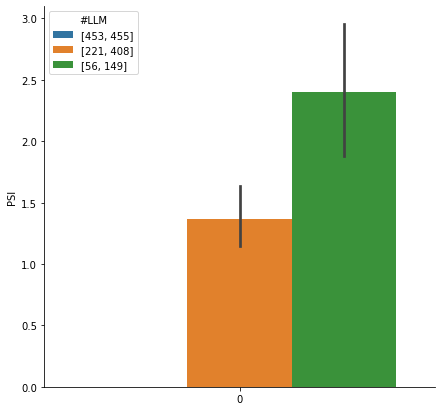

In [36]:

PLOT_PSI4(All_PSI_A,All_PSI_B,
                        All_PSI_C,
                        N_LLM_FOR_ALL_45)

In [37]:
#DiC_Robust_AUC_mlp_iht_lA

In [38]:
#All_KD_B

In [40]:
N_LLM_FOR_ALL_3 = [N_LLM_FOR_ALL[0],N_LLM_FOR_ALL[1],N_LLM_FOR_ALL[2],N_LLM_FOR_ALL[3]]

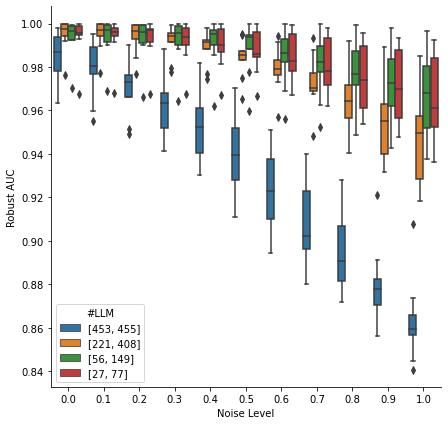

In [41]:
robustness_eval_3(DiC_Robust_AUC_mlp_iht_lA,
                  DiC_Robust_AUC_mlp_iht_lB,
                  DiC_Robust_AUC_mlp_iht_lC,
                  DiC_Robust_AUC_mlp_iht_lD,
                  N_LLM_FOR_ALL_3)

In [42]:
N_LLM_FOR_ALL_44 = [N_LLM_FOR_ALL[0],N_LLM_FOR_ALL[1],N_LLM_FOR_ALL[2]]

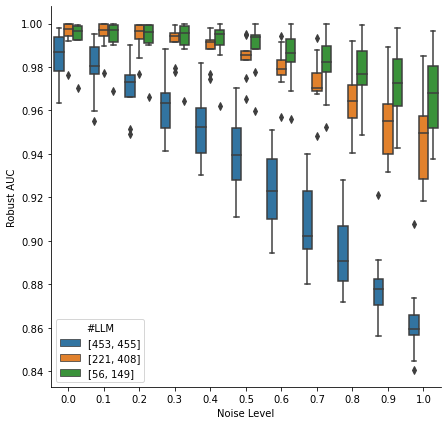

In [43]:
robustness_eval_4(DiC_Robust_AUC_mlp_iht_lA,
                  DiC_Robust_AUC_mlp_iht_lB,
                  DiC_Robust_AUC_mlp_iht_lC,
                  N_LLM_FOR_ALL_44)

**Plot the distance to the base**

In [45]:
#robustness_AUC_shift_2(DiC_Robust_AUC_shift_mlp_iht_lA,DiC_Robust_AUC_shift_mlp_iht_lB,DiC_Robust_AUC_shift_mlp_iht_lC, N_LLM_FOR_ALL_3)

In [46]:
dist_A = All_dist_A[0.0][223]
dist_B = All_dist_B[0.0][223]
dist_C = All_dist_C[0.0][223]
dist_D = All_dist_D[0.0][223]
dist_E = All_dist_E[0.0][223]
dist_F = All_dist_F[0.0][223]

In [47]:
#All_dist_B

In [48]:
pdf_A = All_pdf_A[0.0][223]
pdf_B = All_pdf_B[0.0][223]
pdf_C = All_pdf_C[0.0][223]
pdf_D = All_pdf_D[0.0][223]
pdf_E = All_pdf_E[0.0][223]
pdf_F = All_pdf_F[0.0][223]

In [49]:
#All_pdf_F

No handles with labels found to put in legend.


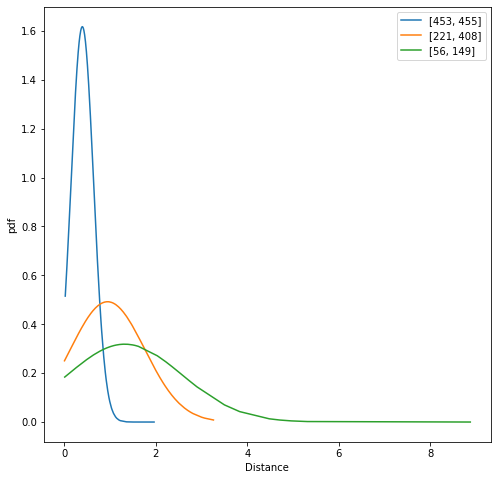

In [50]:
import scipy.stats as stats 
dist_A = np.sort(dist_A)
dist_B = np.sort(dist_B)
dist_C = np.sort(dist_C)
dist_D = np.sort(dist_D)


meanA = np.mean(dist_A)
sdvA = np.std(dist_A)
pdA = stats.norm.pdf(dist_A,meanA,sdvA)

meanB = np.mean(dist_B)
sdvB = np.std(dist_B)
pdB = stats.norm.pdf(dist_B,meanB,sdvB)

meanC = np.mean(dist_C)
sdvC = np.std(dist_C)
pdC = stats.norm.pdf(dist_C,meanC,sdvC)

meanD = np.mean(dist_D)
sdvD = np.std(dist_D)
pdD = stats.norm.pdf(dist_D,meanD,sdvD)



fig , ax = plt.subplots(figsize=(8,8))
plt.legend(loc='upper right')
ax.plot(dist_A,pdA, label=str([min(N_LLM_FOR_ALL_3[0]), max(N_LLM_FOR_ALL_3[0])]))
ax.plot(dist_B,pdB ,label=str([min(N_LLM_FOR_ALL_3[1]),max(N_LLM_FOR_ALL_3[1])]))
ax.plot(dist_C,pdC , label=str([min(N_LLM_FOR_ALL_3[2]),max(N_LLM_FOR_ALL_3[2])]))
#ax.plot(dist_D,pdD , label=str([min(N_LLM_FOR_ALL_3[3]),max(N_LLM_FOR_ALL_3[3])]))
ax.set_xlabel("Distance")
ax.set_ylabel("pdf")
ax.legend()